In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

data = pd.read_csv('df_task_final.csv')

## Basic data exploration

In [2]:
print('\nData types: \n')
print(data.dtypes)

print('\nPercentage of data missing: \n')
perc_null = data.isnull().sum() / data.count() * 100
print(perc_null.map('{:,.2f}%'.format))

print(f'\nNumber of exact duplicates: {data.duplicated().sum()}')

data.head()


Data types: 

Timestamp     object
P1           float64
T1           float64
T2           float64
Ta1          float64
Ta3          float64
Ta4           object
Ta5          float64
Ta6          float64
Ta7          float64
Ta8          float64
Ta_q         float64
v_1           object
power        float64
dtype: object

Percentage of data missing: 

Timestamp    0.00%
P1           0.03%
T1           0.07%
T2           0.00%
Ta1          0.36%
Ta3          0.23%
Ta4          0.37%
Ta5          0.24%
Ta6          0.28%
Ta7          0.24%
Ta8          0.24%
Ta_q         0.24%
v_1          0.00%
power        0.00%
dtype: object

Number of exact duplicates: 0


,Timestamp,P1,T1,T2,Ta1,Ta3,Ta4,Ta5,Ta6,Ta7,Ta8,Ta_q,v_1,power
0,2004-02-10 00:00:00,-262.572912,611.95100,598.11930,181.534245,155.791908,"183,5510776",168.972999,187.873896,191.665459,192.628790,389.347742,low,-275.511342
1,2004-02-10 00:01:00,-262.502827,611.60874,597.32802,182.118922,155.203158,"184,3680832",169.471913,188.462358,192.330486,193.248012,414.523798,low,-275.519129
2,2004-02-10 00:02:00,-262.432774,611.26648,596.53674,183.047085,153.407394,"185,1172925",170.123189,189.107933,193.000879,194.033012,396.883613,low,-275.521336
3,2004-02-10 00:03:00,-262.362689,610.92736,595.74860,183.826767,154.870932,"186,0627518",171.123891,190.142222,193.977434,194.888348,383.059752,low,-275.521336
4,2004-02-10 00:04:00,-262.292604,610.58510,594.95732,184.579713,156.397284,"186,6565326",171.687200,190.586563,194.514055,195.600808,386.056265,low,-275.521336


#### Observations:
- Standard intexing is used instead of actual timestamps
- Feature 'Ta4' requires data type change from string to float
- Percentage of data missing is very low, allowing for naive appending techniques
- There are no duplicates

#### Basic cleanup
- Fix indexing and datatypes
- Use linear interpolation to fill missing time-series data (If larger % of data would be missing, we would resort to ARIMA modeling to retain statistical properties of time-series)

In [3]:
# Cast Ta4 into numerical data type
data['Ta4'] = data['Ta4'].str.replace(',', '.')
data['Ta4'] = pd.to_numeric(data['Ta4'])

# DateTime STR -> DT
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Check whether samples are equidistant in time
print('The time difference between samples is uniquely: ')
print(f"{data['Timestamp'].diff().dt.total_seconds().unique()[1]:.2f} seconds")
# Make timestamps df index
data = data.set_index('Timestamp')

# Impute data
data_tidy = data.interpolate(method='linear')

print('\nUnique values of v_1 sensor activity are:')
print(data_tidy['v_1'].unique())

The time difference between samples is uniquely: 
60.00 seconds

Unique values of v_1 sensor activity are:
['low' 'S' 'M' 'L']


#### Details of some features
- Timestamps are equidistant
- Sensor activity can have 4 distinct values, it may be important to investigate how it affects the collected data

### Visualization of data

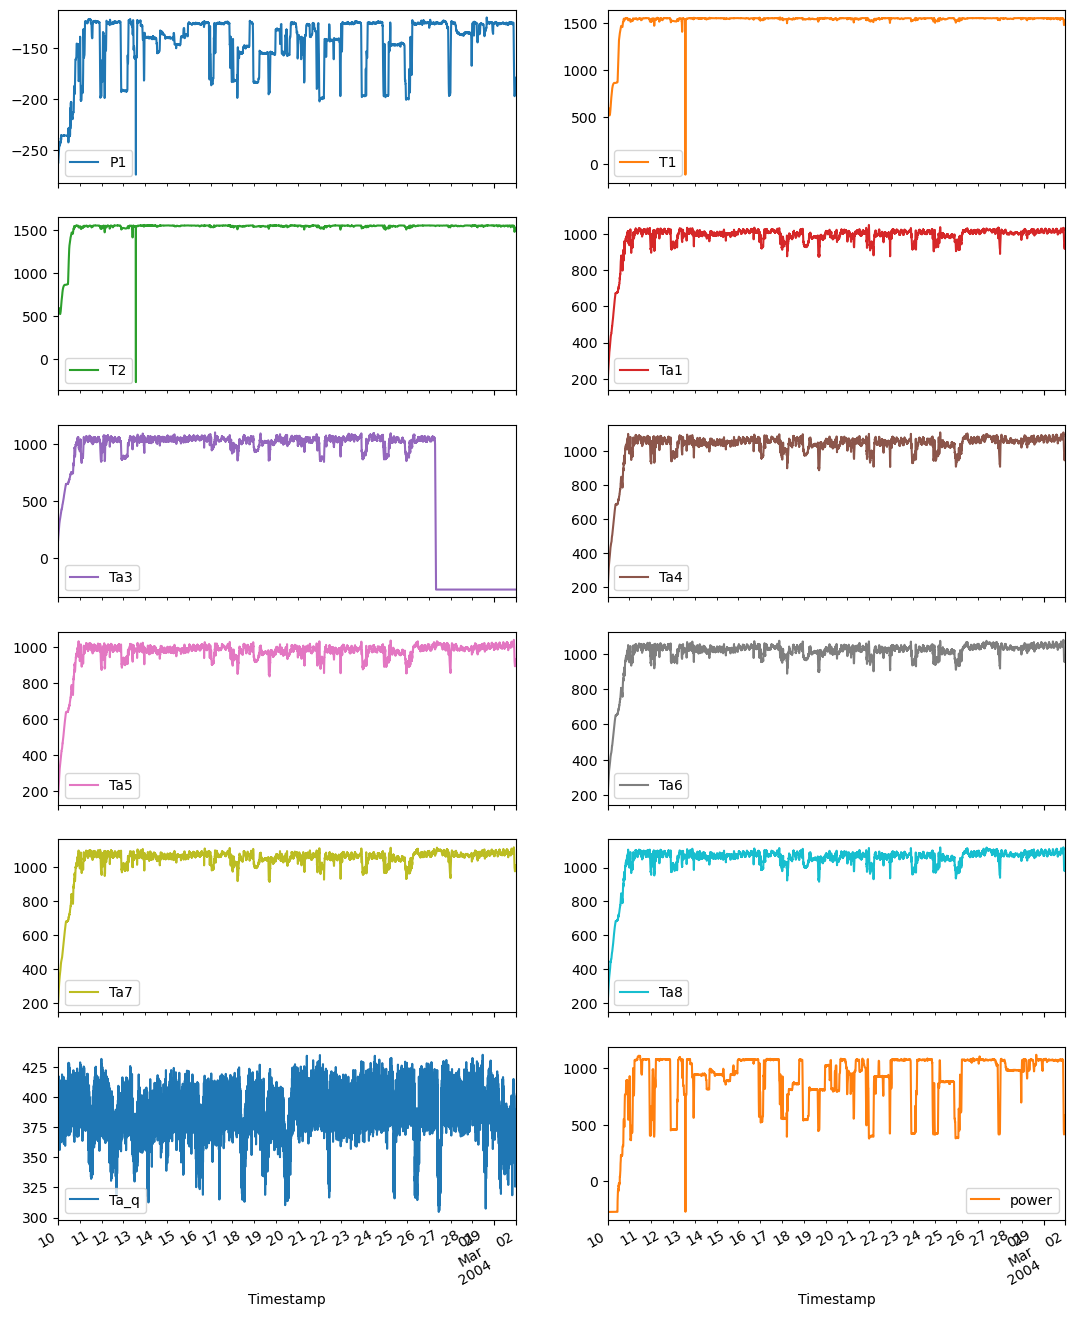

In [4]:
data_tidy.plot(subplots=True, layout=(10,2), figsize=(13, 30))
plt.show()

#### Visual inspection of data
- The system had a start-up period of approximately one day
- P1, T1, T2 as well as Power dropped sharply on the 13th Feb.
 - Since multiple sensor show this (correlation), it is most likely real event and not a measurement error
 - Sensors Ta1 - Ta8 show different correlation
- Sensor Ta3 stops measuring properly on 27th Feb.


#### Drop event (13th feb.) investigation

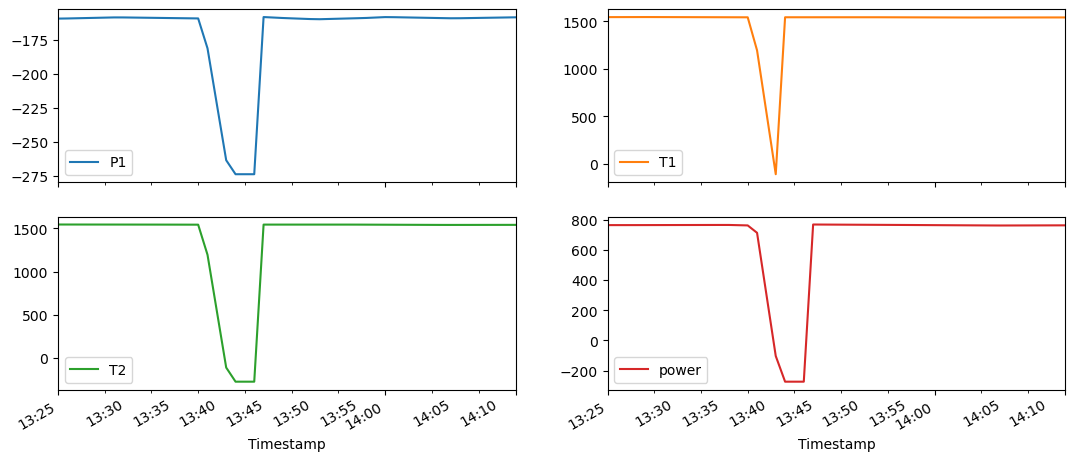

In [5]:
data_tidy[['P1', 'T1', 'T2', 'power']].iloc[5125:5175].plot(subplots=True, layout=(10, 2), figsize=(13, 30))
plt.show()

Since I dont have knowledge of thermal capacity of the system I can hardly judge the possibility of such event, however:
- Temperature measurement reads below zero (A bit long strech but possible)
- Reading bottoms on some limit, which is possible for thermocouples
- In case of error I would expect NaN or 0, not a negative number, also descend was gradual
- I decided to leave the event in, it is short (6 datapoints) and wont affect model much

#### Ta3 sensor failure investigation

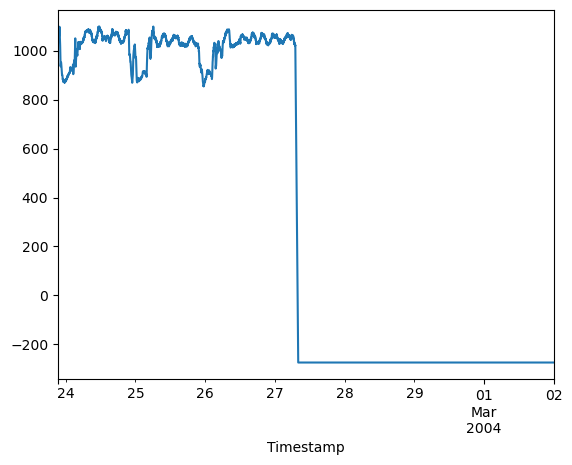

In [6]:
data_tidy['Ta3'].iloc[20000:].plot()
plt.show()

In this case I am inclined to believe sensor failed (Thermocouple outputs 0 V which is interpreted as low temp.)
- Mainly because keeping segment of high temperature system below zero feels outowordly.
- I would probably disregard entire Ta3, since in time-series the latest data have the biggest importance
- Additionaly it is highly correlated with others Ta{} sensors so there is virtually no loss of useful information

### Correlation investigation

In [7]:
data_tidy.corr(method='pearson')

,P1,T1,T2,Ta1,Ta3,Ta4,Ta5,Ta6,Ta7,Ta8,Ta_q,power
P1,1.000000,0.608054,0.608267,0.753591,-0.056673,0.773267,0.763160,0.757907,0.762320,0.763038,-0.086377,0.989535
T1,0.608054,1.000000,0.989382,0.935485,0.090994,0.915178,0.920518,0.928955,0.924695,0.924812,-0.023441,0.701009
T2,0.608267,0.989382,1.000000,0.925906,0.089156,0.905589,0.910895,0.919308,0.915048,0.915144,-0.021506,0.699442
Ta1,0.753591,0.935485,0.925906,1.000000,0.046931,0.993399,0.994078,0.992809,0.993709,0.994185,-0.052248,0.816257
Ta3,-0.056673,0.090994,0.089156,0.046931,1.000000,0.029325,0.025425,0.020283,0.026545,0.030352,-0.018494,-0.035923
Ta4,0.773267,0.915178,0.905589,0.993399,0.029325,1.000000,0.999531,0.995756,0.998192,0.998550,-0.066486,0.831687
Ta5,0.763160,0.920518,0.910895,0.994078,0.025425,0.999531,1.000000,0.997532,0.999236,0.999422,-0.065555,0.823472
Ta6,0.757907,0.928955,0.919308,0.992809,0.020283,0.995756,0.997532,1.000000,0.999314,0.998924,-0.063024,0.820526
Ta7,0.762320,0.924695,0.915048,0.993709,0.026545,0.998192,0.999236,0.999314,1.000000,0.999908,-0.065168,0.823717
Ta8,0.763038,0.924812,0.915144,0.994185,0.030352,0.998550,0.999422,0.998924,0.999908,1.000000,-0.065018,0.824385


~Perfect correlations:
- as seen in plots, Ta{} sensors are almost perfectly correlated, Ta3 missing data is not a problem (from DS perspective)
- same applies to T1 and T2
- another almost perfect correlation is in power & pressure [P1]

Strong correlations:
- Power of the system is highly correlated to individial temperatures
- Pressure of the system is highly correlated to individial temperatures

Uncorrelated:
- Taq is not correlated to anything

### Time-series analysis

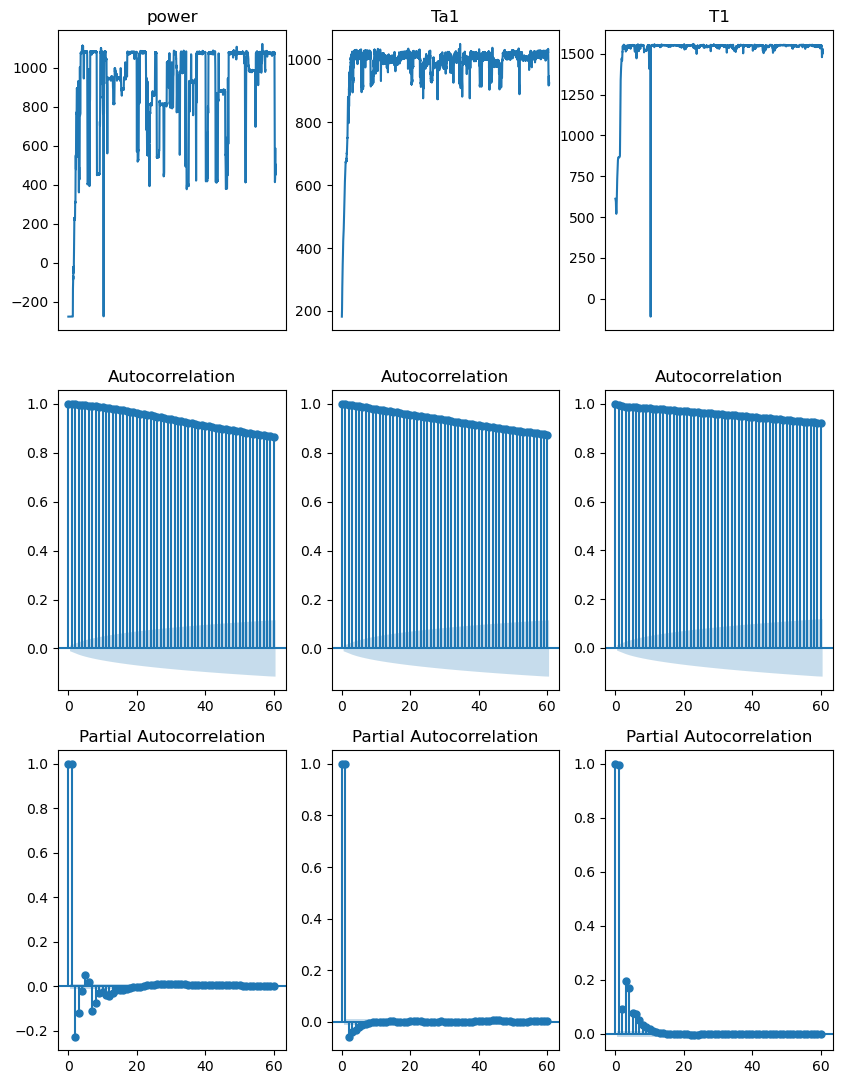

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plt_ts_corr(cols, lags=60):
    n = len(cols)
    fig, ax = plt.subplots(nrows=3, ncols=n, figsize=(10, 15))
    
    for i, col in enumerate(cols):
        col.plot(ax=ax[0][i], use_index=False, xticks=[])
        ax[0][i].set_title(col.name)
        plot_acf(col.to_numpy(), missing='drop', lags=lags, ax=ax[1][i])
        plot_pacf(col.dropna().to_numpy(), method="ldadjusted", lags=lags, ax=ax[2][i])
    plt.show()

plt_ts_corr([data_tidy['power'], data_tidy['Ta1'], data_tidy['T1']])

#### Observations:
- All time series show significant AutoRegressive character
- With exception of T1 there is ale Moving average characteristic present in PACF
- It may be more beneficial to resample the series to higher timeframe (1H) and look for daily seasonality

### Resampling, intraday seasonality

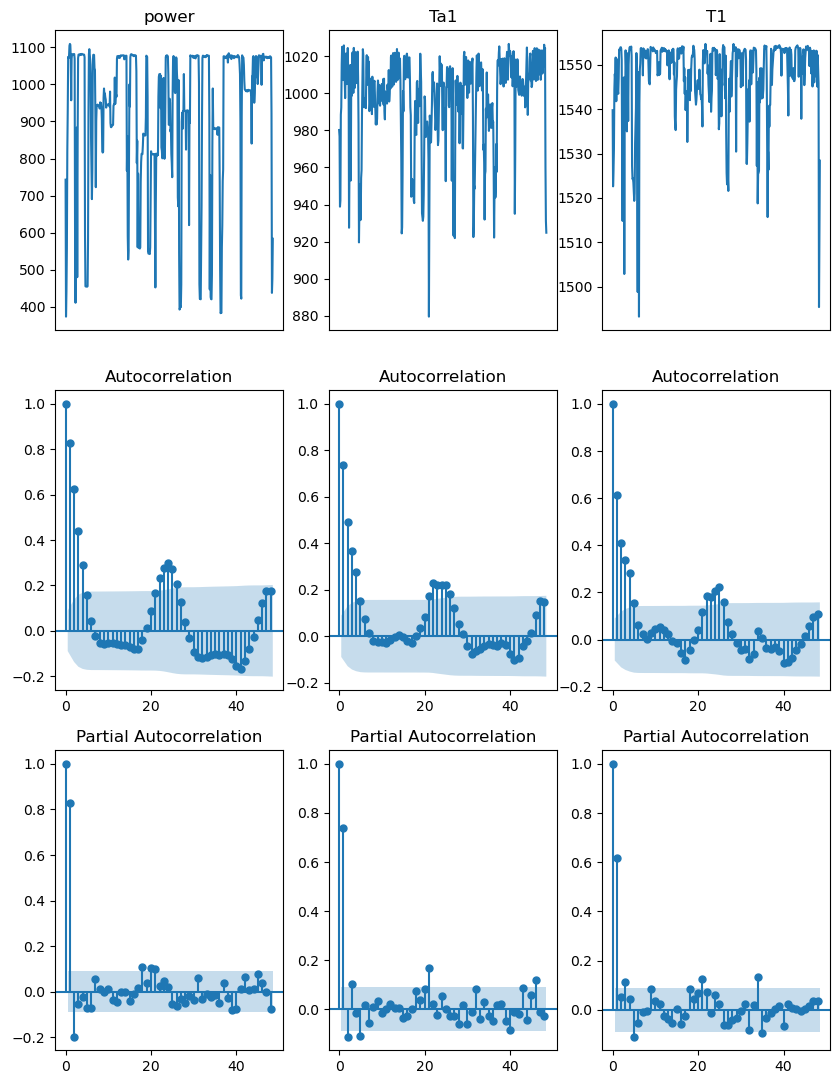

In [9]:
# Resample to show hourly datapoints values at mean value for given hour
# Plot ACF/PACF for 48 lags (2 days)
data_hourly = data_tidy.resample('H').mean()
plt_ts_corr([data_hourly['power'].iloc[24:], data_hourly['Ta1'].iloc[24:], data_hourly['T1'].iloc[24:]], lags=48)

#### Observations:
- We can see that ACF show obvious, yet dispersed 24H seasonality
- We can do overlay plots of each day as well as their average to get idea about the intraday pattern

20


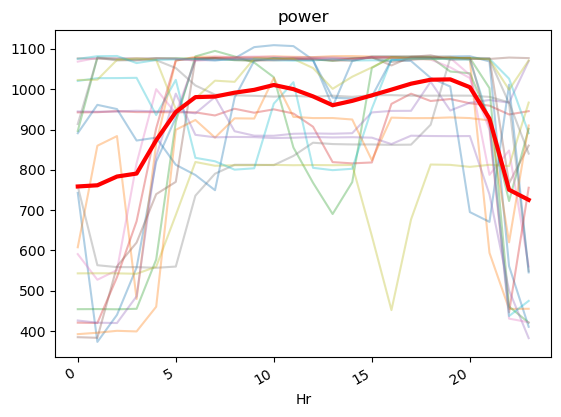

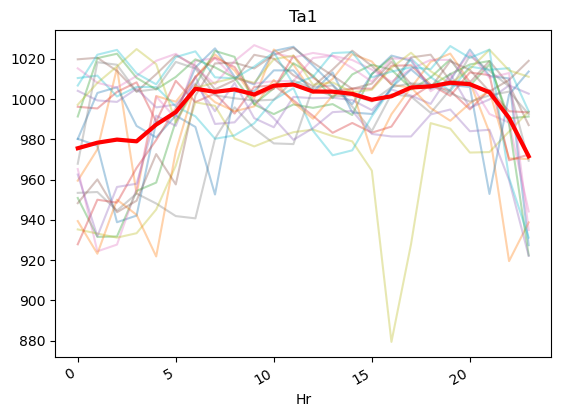

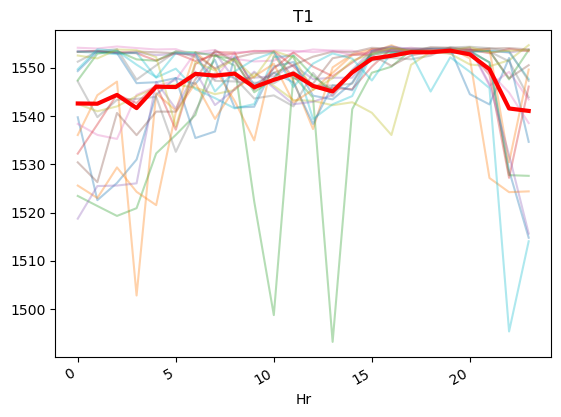

In [10]:
# Nested loops draw plot for each investigated feature
# Plot shows each day hourly values as well as their average

hours = 24
n_days = int(data_hourly.shape[0]/hours)-1          # calculate n of days - 1 (we ignore first day)  
print(n_days)

avg1 = avg2 = avg3 = pd.Series(np.full(hours, 0))   # initialize empty Series to calculate averages
averages = [avg1, avg2, avg3]
features = ['power', 'Ta1', 'T1']

for i, ftr in enumerate(features):                  # For each feature plot a daily plot overlay and add values to avg Series
    for j in range(1, n_days+1):
        plt.figure(i)
        day = data_hourly.iloc[j*hours:j*hours+hours][ftr]
        day.plot(use_index=False, alpha=0.35)
        averages[i] = averages[i] + day.reset_index(drop=True)
    averages[i] /= n_days    # calculate average
    plt.plot(averages[i], color='red', linewidth=3)
    plt.title(ftr)
    plt.xlabel('Hr')

plt.show()    

#### Observations:
- In all cases, but most significantly in the 'power' series there is evident pattern
- System 'cools down' over night and ramps up again each morning
- There is few completely flat series (possibly weekends, special operations etc.)

### Other assumptions:
- Dynamic stable system whose state can be defined by power and temperature
- Physically: power drives pressure and temperature
- Systematically: temperature target is set and feedback (PID like controller) drives power
    - temp. target changes during the day
    - its nonlinear relationship, but can be easily modelled
- If we had explicit knowledge of temp.target as f(t) and PID/deefback loop settings, we could use them exogenius data in state space model.    


#### Creating smoothed (minute based) daily average to use as exogenius regressor

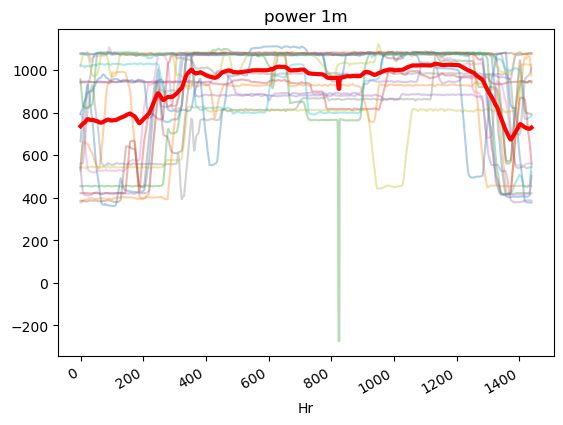

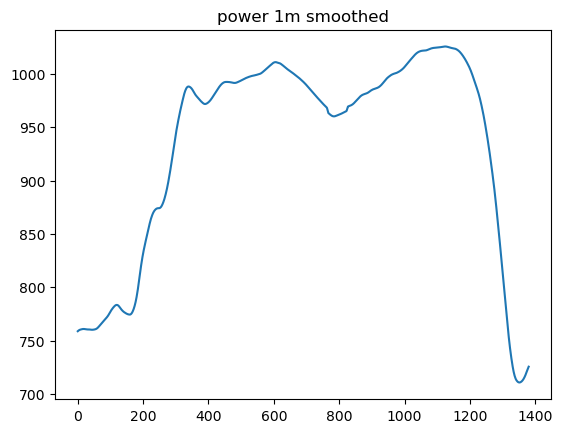

In [23]:
minutes = 1440
power_avg_1m = pd.Series(np.full(minutes, 0))

# Same loop as above except we use minute data
for j in range(1, n_days+1):
    plt.figure(i)
    day = data_tidy.iloc[j*minutes:j*minutes+minutes]['power']
    day.plot(use_index=False, alpha=0.35)
    power_avg_1m = power_avg_1m + day.reset_index(drop=True)
power_avg_1m /= n_days    # calculate average

# Plot overlayed daily plots
plt.plot(power_avg_1m, color='red', linewidth=3)
plt.title('power 1m')
plt.xlabel('Hr')
plt.show()

# we smooth that daily average
def ma(array, w):
    return np.convolve(array, np.ones(w), 'valid') / w

# Plot smoothed daily average
power_avg_smooth = ma(power_avg_1m, 60)
plt.plot(power_avg_smooth)
plt.title('power 1m smoothed')
plt.show()

In [24]:
power_avg_smooth = pd.Series(power_avg_smooth)
power_avg_smooth.to_csv('power_D_avg.csv')